# Convolutional Neural Networks for Image Classification (Computer Vision)

Convolutional Neural Networks (CNNs) are commonly used in tasks involving image analysis as they are designed to extract complex features from images due to its hierarchical nature. 

In this project, a simple CNN (from scratch) using TinyVGG architecture will be used to classify images into six different categories:

0. Building
1. Forest
2. Glacier
3. Mountain
4. Sea
5. Street

The dataset can be found here: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

Other datasets that are common benchmarks for image classification are CIFAR-10 and CIFAR-100 datasets.

## 0. Imports & Hyperparameters

In [1]:
# Necessary global imports
import os
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from torch.utils.data import DataLoader
import random
from timeit import default_timer as timer 

# Import necessary functions from helper_functions.py
from helper_functions import accuracy_fn, print_train_time, plot_loss_curves

# Set torch manual seed
torch.manual_seed(42)

# Hyperparameters
BATCH_SIZE = 64
CONV_KERNEL_SIZE = 3
CONV_PADDING = 1
POOL_STRIDE = 2
POOL_KERNEL_SIZE = 2
HIDDEN_UNITS = 10
LEARNING_RATE = 1e-3
CONV_DROPOUT = 0.20
MLP_DROPOUT = 0.30
EPOCHS = 10
NUM_ROWS = 3
NUM_COLS = 3
PLOT_STEPS = 1
PRINT_STEPS = 1

# Bidirectional mappings between classes and their respective indices
OUTPUT_CLASSES = {
    'buildings' : 0,
    'forest' : 1,
    'glacier' : 2,
    'mountain' : 3,
    'sea' : 4,
    'street' : 5
}

GET_CLASS = {
    0 : 'Building',
    1 : 'Forest',
    2 : 'Glacier',
    3 : 'Mountain',
    4 : 'Sea',
    5 : 'Street'
}

torch.__version__

'2.5.1+cpu'

## 1. Data Processing

We will be using OpenCV to process image data and convert each image into tensors later on for model training and evaluation. Each image is of dimension 150x150 and will have RBG colour channels.

In [2]:
train_data, test_data, train_targets, test_targets = [], [], [], []

# Loop through all the data and convert into numerical formats
for class_type in OUTPUT_CLASSES:
    train_files = os.listdir(f"data//seg_train//{class_type}")
    test_files = os.listdir(f"data//seg_test//{class_type}")
    
    for file in train_files:
        image = cv2.imread(f"data//seg_train//{class_type}//{file}")
        class_value = OUTPUT_CLASSES[class_type]

        if (image is not None) and (len(image) == 150) and (len(image[0]) == 150) and (len(image[0][0]) == 3):
            train_data.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(int))
            train_targets.append(class_value)

    for file in test_files:
        image = cv2.imread(f"data//seg_test//{class_type}//{file}")
        class_tensor = torch.tensor(OUTPUT_CLASSES[class_type])

        if (image is not None) and (len(image) == 150) and (len(image[0]) == 150) and (len(image[0][0]) == 3):
            test_data.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(int))
            test_targets.append(class_value)

len(train_data), len(test_data), len(train_targets), len(test_targets)

(13986, 2993, 13986, 2993)

In [3]:
# Let's see what a sample data looks like
test_data[0]

array([[[ 92, 119, 174],
        [114, 140, 189],
        [101, 124, 166],
        ...,
        [109, 148, 207],
        [110, 149, 208],
        [110, 149, 208]],

       [[ 86, 113, 160],
        [157, 181, 227],
        [141, 163, 204],
        ...,
        [106, 146, 205],
        [107, 147, 206],
        [107, 147, 206]],

       [[128, 152, 186],
        [138, 161, 195],
        [156, 176, 213],
        ...,
        [103, 145, 205],
        [103, 145, 205],
        [103, 145, 205]],

       ...,

       [[198, 207, 224],
        [198, 207, 224],
        [197, 206, 223],
        ...,
        [224, 230, 242],
        [226, 233, 243],
        [228, 235, 245]],

       [[195, 206, 224],
        [195, 206, 224],
        [195, 206, 224],
        ...,
        [224, 230, 242],
        [228, 235, 245],
        [232, 239, 249]],

       [[192, 205, 222],
        [192, 205, 222],
        [194, 205, 223],
        ...,
        [223, 229, 241],
        [230, 237, 247],
        [234, 241, 251]]

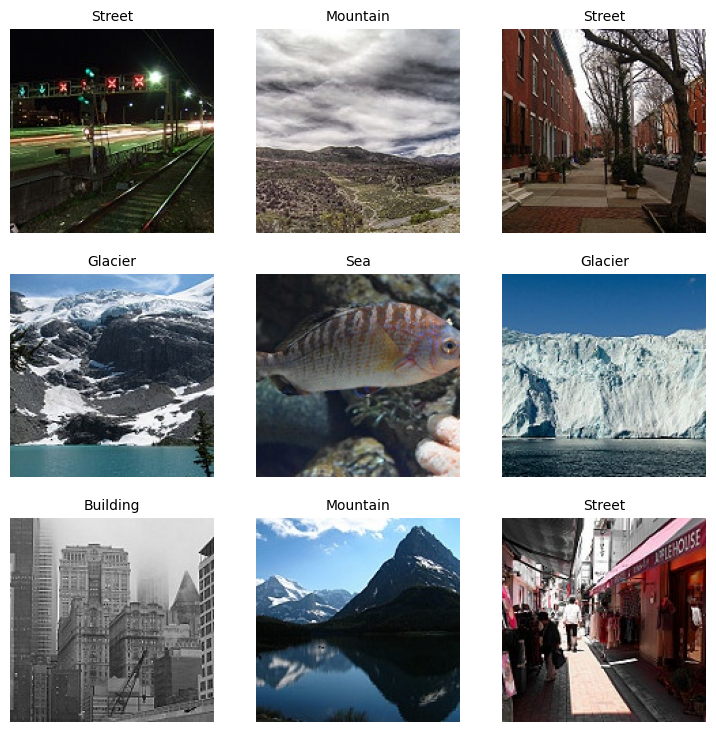

In [4]:
# Visualize 9 random test samples
plt.figure(figsize=(9, 9))
i = 1

for idx, sample in random.sample(list(enumerate(test_data)), k=9):
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(sample.tolist())
    plt.title(GET_CLASS[test_targets[idx]], fontsize=10)
    plt.axis(False);

    i += 1

In [5]:
# Let's see how we will convert our data into torch tensors then normalize it (by dividing each by 255.0) for faster model training

temp_tensor = torch.moveaxis(torch.tensor(test_data[i], dtype=torch.float32), -1, 0) / 255.0
print(f"temp_tensor dtype: {temp_tensor.dtype} | temp_tensor shape: {temp_tensor.shape}")
print(temp_tensor)

temp_tensor dtype: torch.float32 | temp_tensor shape: torch.Size([3, 150, 150])
tensor([[[0.5451, 0.6157, 0.6980,  ..., 0.2863, 0.2824, 0.2824],
         [0.6196, 0.7176, 0.8431,  ..., 0.2902, 0.2863, 0.2824],
         [0.6471, 0.7137, 0.7843,  ..., 0.2745, 0.2706, 0.2706],
         ...,
         [0.2196, 0.1451, 0.2588,  ..., 0.0784, 0.1255, 0.1216],
         [0.1686, 0.3647, 0.2353,  ..., 0.0314, 0.0510, 0.0510],
         [0.1725, 0.2000, 0.1765,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.5961, 0.6549, 0.7176,  ..., 0.3843, 0.3843, 0.3843],
         [0.6549, 0.7529, 0.8549,  ..., 0.3882, 0.3882, 0.3843],
         [0.6627, 0.7216, 0.7843,  ..., 0.3725, 0.3686, 0.3686],
         ...,
         [0.2588, 0.1608, 0.2078,  ..., 0.0745, 0.1255, 0.1216],
         [0.2078, 0.3843, 0.2039,  ..., 0.0353, 0.0549, 0.0588],
         [0.2118, 0.2157, 0.1608,  ..., 0.0157, 0.0157, 0.0157]],

        [[0.6196, 0.6588, 0.6941,  ..., 0.5020, 0.4902, 0.4902],
         [0.6745, 0.7490, 0.8275,  ..., 0.5

In [6]:
# Initialize DataLoaders to split data into batches
train_dataloader = DataLoader(
    [(torch.moveaxis(torch.tensor(train_data[i], dtype=torch.float32), -1, 0) / 255.0, train_targets[i]) for i in range(len(train_data))],
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    [(torch.moveaxis(torch.tensor(test_data[i], dtype=torch.float32), -1, 0) / 255.0, test_targets[i]) for i in range(len(test_data))],
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 219 batches of 64
Length of test dataloader: 47 batches of 64


## 2. Creating CNN Model

We will build our CNN model inspired by the TinyVGG architecture, but with modifications, being:
- Batch Normalization
- Dropouts

The original inspiration for this architecture: https://poloclub.github.io/cnn-explainer/

Of course, more sophisticated CNN models might work better with this dataset. However, for the sake of this project, our model will suffice.

In [7]:
# Build CNN using a modified TinyVGG architecture
# The original inspiration for this architecture: https://poloclub.github.io/cnn-explainer/
class IntelCNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int) -> None:
        super().__init__()

        self.convolution_layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=POOL_KERNEL_SIZE,
                stride=POOL_STRIDE
            ),
            nn.Dropout(p=CONV_DROPOUT)
        )

        self.convolution_layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=CONV_KERNEL_SIZE,
                padding=CONV_PADDING,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=POOL_KERNEL_SIZE,
                stride=POOL_STRIDE
            ),
            nn.Dropout(p=CONV_DROPOUT)
        )
        
        self.multilayer_perception = nn.Sequential( # This is really just a fully-connected and feed-forward layer for classification
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*(37**2), out_features=hidden_units),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=MLP_DROPOUT),
            nn.Linear(in_features=hidden_units, out_features=hidden_units)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convolution_layer_1(x)
        x = self.convolution_layer_2(x)
        x = self.multilayer_perception(x)
        
        return x

In [8]:
# Model initialization
model = IntelCNN(
    input_shape=3, # the number of colour channels
    output_shape=len(OUTPUT_CLASSES), # the number of output classes (in our case, 6)
    hidden_units=HIDDEN_UNITS # in accordance with TinyVGG
)

model

IntelCNN(
  (convolution_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (convolution_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## 3. Training & Testing Model

In [9]:
# Setup loss function and optimizer for training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)

In [12]:
# Model training procedure
def train(model, dataloader, loss_fn, optimizer):
    cur_loss, cur_acc = 0.0, 0.0
    model.train()

    for X, y in dataloader:
        logits = model(X).squeeze()

        # Remember that nn.CrossEntropyLoss expected raw logits, so sigmoid function unnecessary
        loss = loss_fn(logits, y)
        cur_loss += loss.item()

        # When calculating accuracy, however, softmax is needed to output actual predictive values
        pred = torch.softmax(logits, dim=-1).argmax(dim=-1)
        acc = accuracy_fn(y_true=y, y_pred=pred)
        cur_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    cur_loss /= len(dataloader)
    cur_acc /= len(dataloader)
    
    return cur_loss, cur_acc

# Model testing procedure
def test(model, dataloader, loss_fn, optimizer=None):
    cur_loss, cur_acc = 0.0, 0.0
    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            logits = model(X).squeeze()

            loss = loss_fn(logits, y)
            cur_loss += loss.item()

            pred = torch.softmax(logits, dim=-1).argmax(dim=-1)
            acc = accuracy_fn(y_true=y, y_pred=pred)
            cur_acc += acc

        cur_loss /= len(dataloader)
        cur_acc /= len(dataloader)

    return cur_loss, cur_acc

In [13]:
START_TIME = timer()

# Store loss and accuracy for model evaluation
all_train_losses, all_test_losses = [], []
all_train_acc, all_test_acc = [], []

# Calculate running loss and accuracy during training
running_train_loss, running_test_loss = 0.0, 0.0
running_train_acc, running_test_acc = 0.0, 0.0

# Training and testing loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer)
    test_loss, test_acc = test(model, test_dataloader, loss_fn, optimizer)

    running_train_loss += train_loss
    running_test_loss += test_loss

    running_train_acc += train_acc
    running_test_acc += test_acc

    if (epoch + 1) % PLOT_STEPS == 0:
        all_train_losses.append(running_train_loss / PLOT_STEPS)
        all_test_losses.append(running_test_loss / PLOT_STEPS)

        all_train_acc.append(running_train_acc / PLOT_STEPS)
        all_test_acc.append(running_test_acc / PLOT_STEPS)

        running_train_loss, running_test_loss = 0.0, 0.0
        running_train_acc, running_test_acc = 0.0, 0.0

    if (epoch + 1) % PRINT_STEPS == 0:
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

END_TIME = timer()

TOTAL_TRAIN_TIME = print_train_time(
    start=START_TIME,
    end=END_TIME,
    device='cpu'
)

Epoch: 1 | Train Loss: 1.6095 | Test Loss: 1.1390 | Train Acc: 49.1283 | Test acc: 70.3315
Epoch: 2 | Train Loss: 1.0689 | Test Loss: 0.8214 | Train Acc: 64.6169 | Test acc: 73.4741
Epoch: 3 | Train Loss: 0.8771 | Test Loss: 0.8305 | Train Acc: 68.4088 | Test acc: 68.9400
Epoch: 4 | Train Loss: 0.7812 | Test Loss: 0.6925 | Train Acc: 71.0272 | Test acc: 75.4892
Epoch: 5 | Train Loss: 0.7251 | Test Loss: 0.6551 | Train Acc: 73.0866 | Test acc: 75.4430
Epoch: 6 | Train Loss: 0.6908 | Test Loss: 0.6246 | Train Acc: 74.0204 | Test acc: 77.5578
Epoch: 7 | Train Loss: 0.6556 | Test Loss: 0.6489 | Train Acc: 74.9815 | Test acc: 75.2537
Epoch: 8 | Train Loss: 0.6171 | Test Loss: 0.5777 | Train Acc: 76.3925 | Test acc: 78.4629
Epoch: 9 | Train Loss: 0.5918 | Test Loss: 0.5535 | Train Acc: 76.9965 | Test acc: 80.6292
Epoch: 10 | Train Loss: 0.5628 | Test Loss: 0.5655 | Train Acc: 78.2182 | Test acc: 79.8592

Train time on cpu: 1857.548 seconds


Note that I only trained for 10 epochs, and training for longer would have resulted in further increase in accuracy.

## 4. Saving Model

In [14]:
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "intel_image_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\intel_image_cnn.pth


In [15]:
# Load saved model
loaded_state_dict = torch.load(f=MODEL_SAVE_PATH, weights_only=False)

loaded_model = IntelCNN(
    input_shape=3,
    output_shape=len(OUTPUT_CLASSES),
    hidden_units=HIDDEN_UNITS
)

# Load in the saved state_dict()
loaded_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [19]:
# Test loaded model accuracy to make sure everything is working properly
test_loss, test_acc = test(
    model=loaded_model,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}%")

Test Loss: 0.5664 | Test Acc: 79.8286%


## 5. Evaluating Model

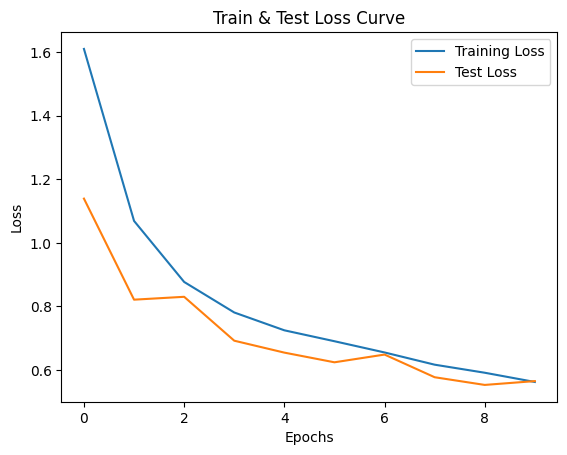

In [20]:
# Plot train and test loss
plt.title("Train & Test Loss Curve")
plt.plot(all_train_losses)
plt.plot(all_test_losses)
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss');

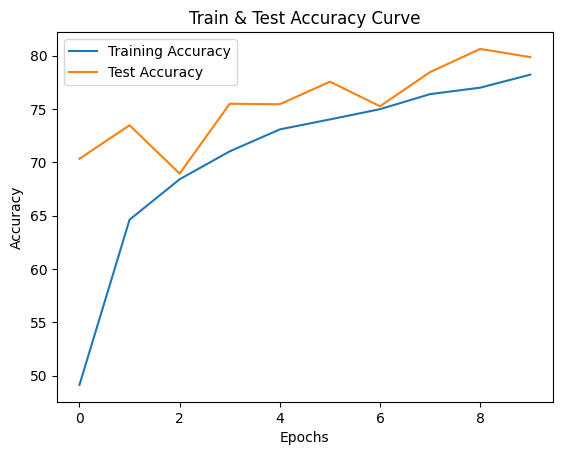

In [21]:
# Plot train and test accuracy
plt.title("Train & Test Accuracy Curve")
plt.plot(all_train_acc)
plt.plot(all_test_acc)
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

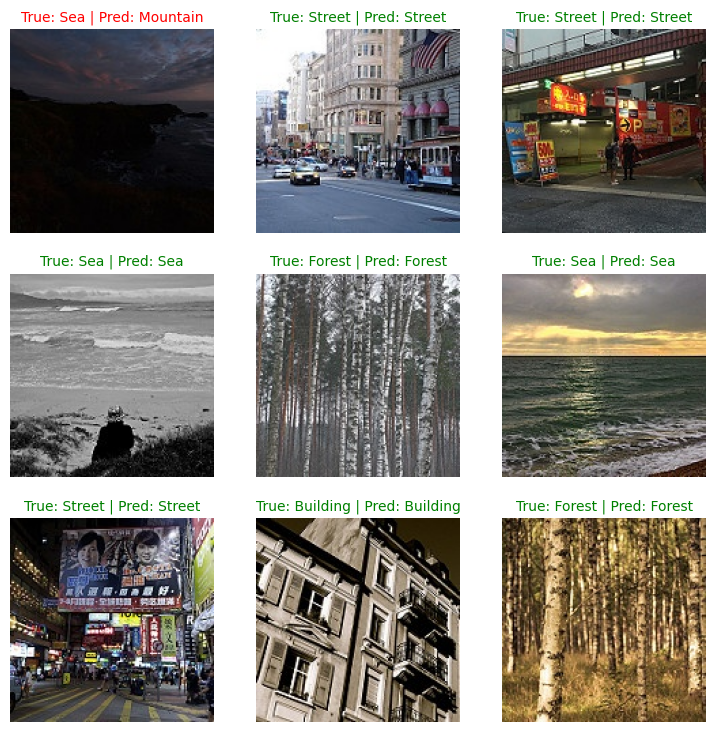

In [23]:
# Visualize how accurate our model is using random test samples
plt.figure(figsize=(9, 9))
i = 1

for idx, sample in random.sample(list(enumerate(test_data)), k=9):
    X = torch.moveaxis(torch.tensor(test_data[idx], dtype=torch.float32), -1, 0) / 255.0

    loaded_model.eval()
    with torch.inference_mode():
        logit = loaded_model(X.unsqueeze(dim=0))
        predicted_target = GET_CLASS[int(logit.argmax(dim=1).item())]
    
    true_target = GET_CLASS[test_targets[idx]]
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(sample.tolist())

    title = f"True: {true_target} | Pred: {predicted_target}"

    if predicted_target == true_target:
        plt.title(title, c='g', fontsize=10)
    else:
        plt.title(title, c='r', fontsize=10)
        
    plt.axis(False);

    i += 1

The end :)